In [88]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate,cross_val_score, validation_curve

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [89]:
df = pd.read_csv("/content/hitters.csv")

In [90]:
#Genel resmi inceleme
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(5))
    print("##################### Tail #####################")
    print(dataframe.tail(5))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.25, 0.50, 0.75, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(322, 20)
##################### Types #####################
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
##################### Head #####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        

In [91]:
#Değişken türlerini belirlemek
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                 dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                 dataframe[col].dtypes == "O"]

  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" ]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols,num_but_cat

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [92]:
#Kategorik değişken analizi
def cat_summary(dataframe, col_name, plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      "Ratio": 100*dataframe[col_name].value_counts() / len(dataframe)}))
  print("################################################")
  if plot:
    sns.countplot(x=dataframe[col_name], data=dataframe)
    plt.show(block=True)

for col in cat_cols:
  cat_summary(df, col, plot=False)

        League  Ratio
League               
A          175 54.348
N          147 45.652
################################################
          Division  Ratio
Division                 
W              165 51.242
E              157 48.758
################################################
           NewLeague  Ratio
NewLeague                  
A                176 54.658
N                146 45.342
################################################


count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
20%     221.800
30%     281.300
40%     321.800
50%     379.500
60%     430.200
70%     490.000
80%     535.600
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64


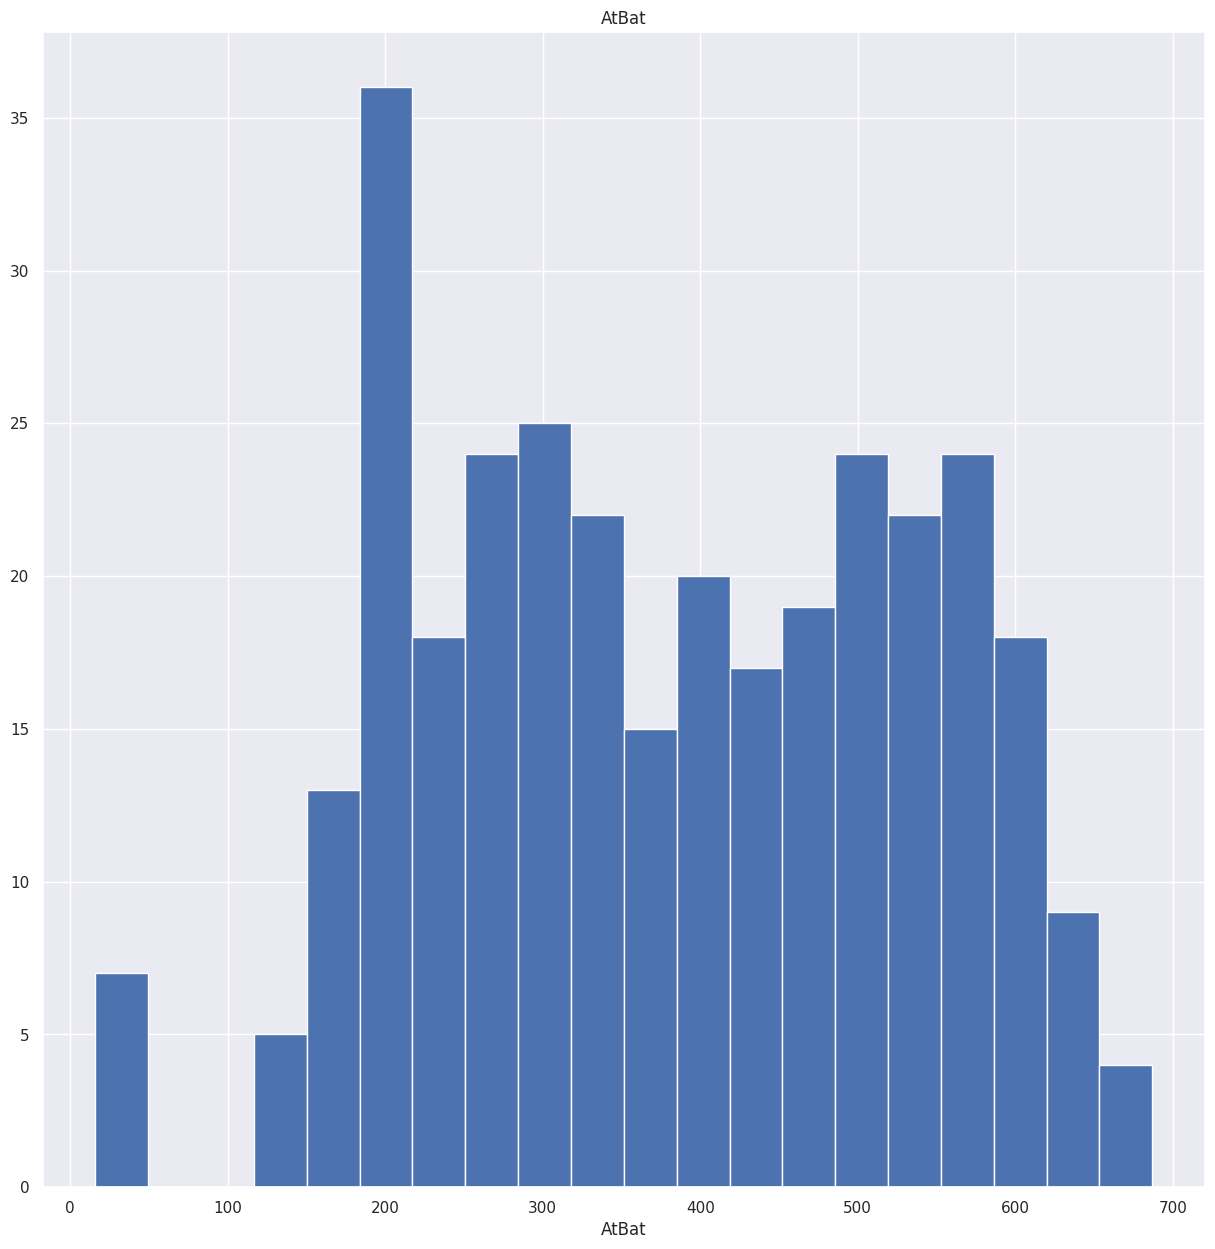

count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
20%      57.000
30%      70.000
40%      82.000
50%      96.000
60%     113.000
70%     128.700
80%     144.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64


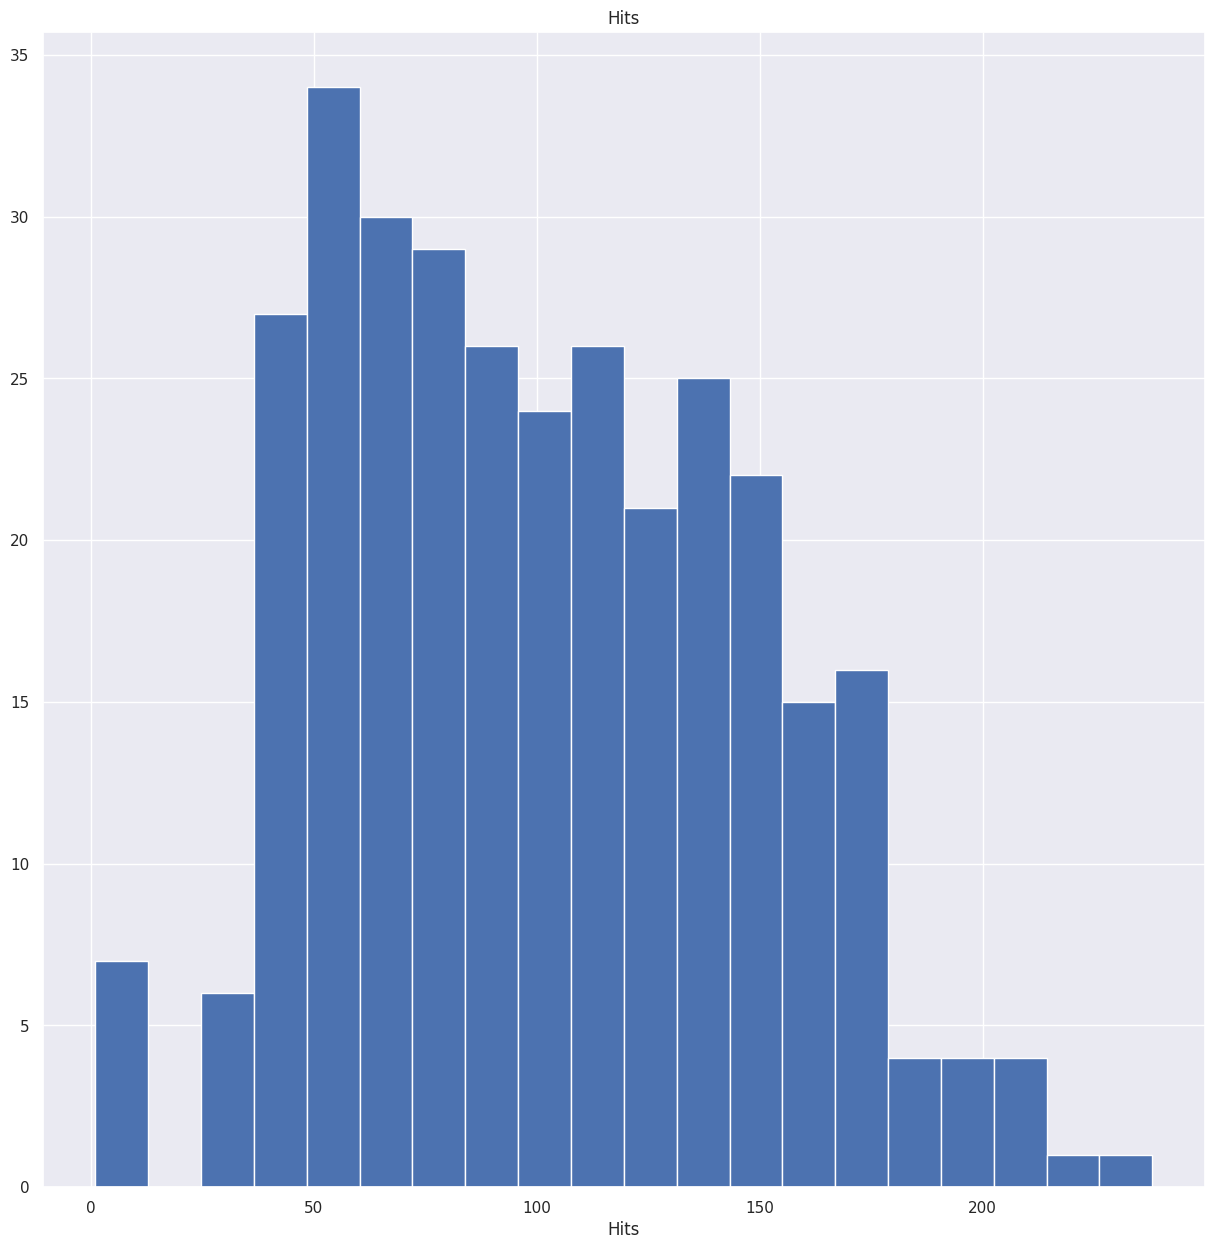

count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       5.000
40%       6.000
50%       8.000
60%      10.600
70%      14.000
80%      18.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64


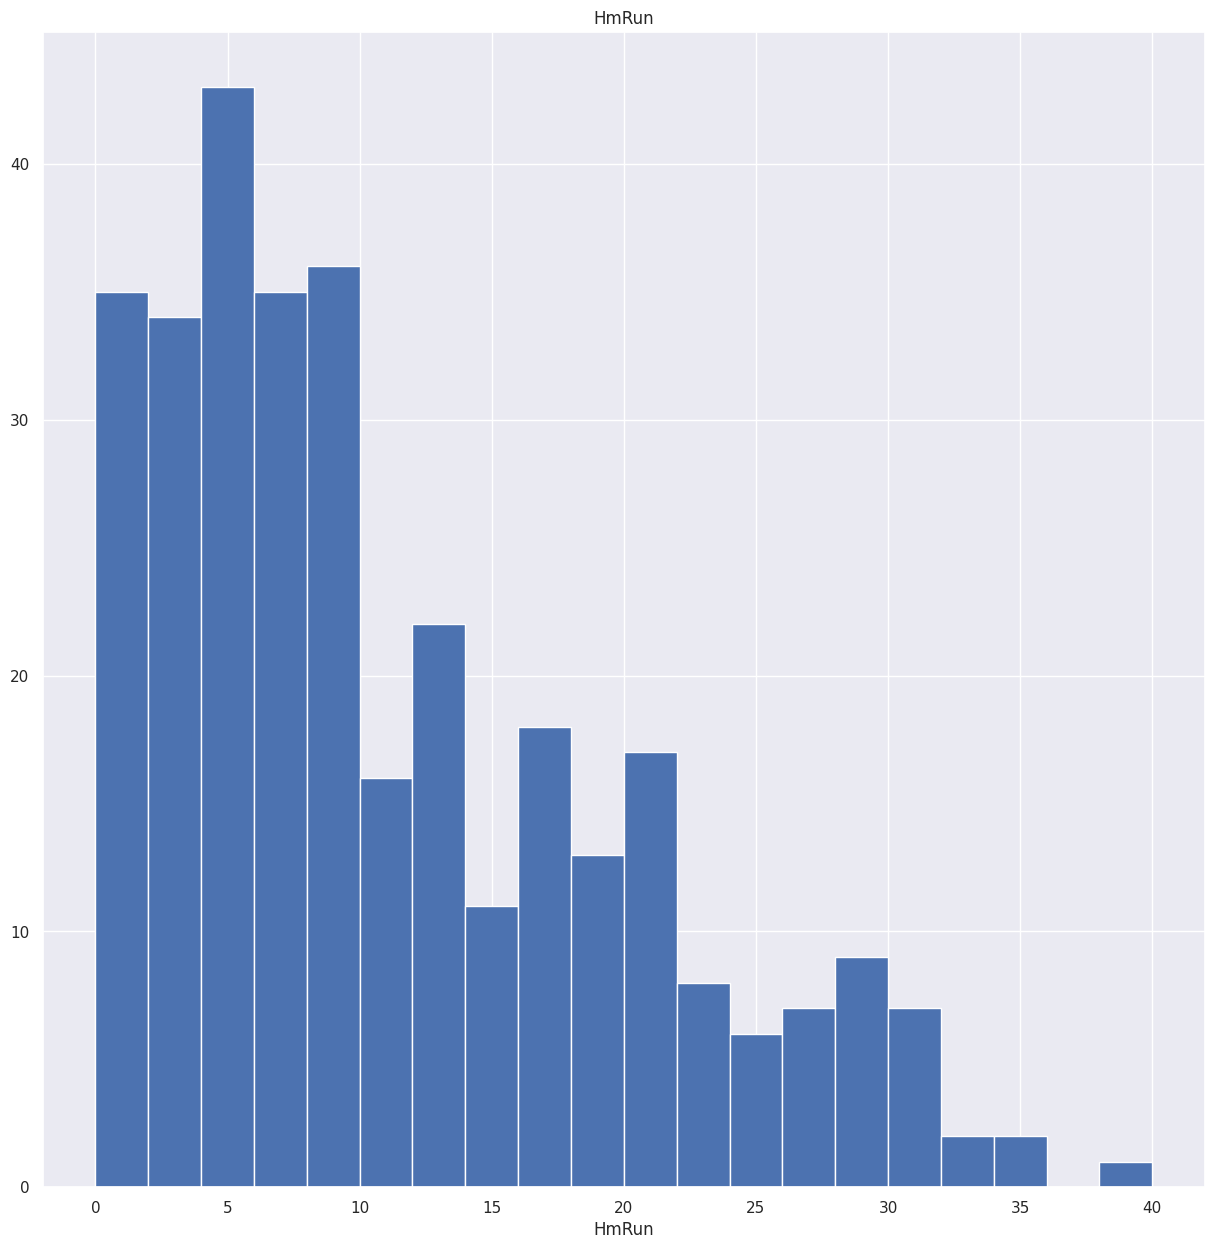

count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
20%      27.000
30%      33.000
40%      41.000
50%      48.000
60%      55.600
70%      66.000
80%      75.800
90%      89.000
95%      94.000
99%     107.790
max     130.000
Name: Runs, dtype: float64


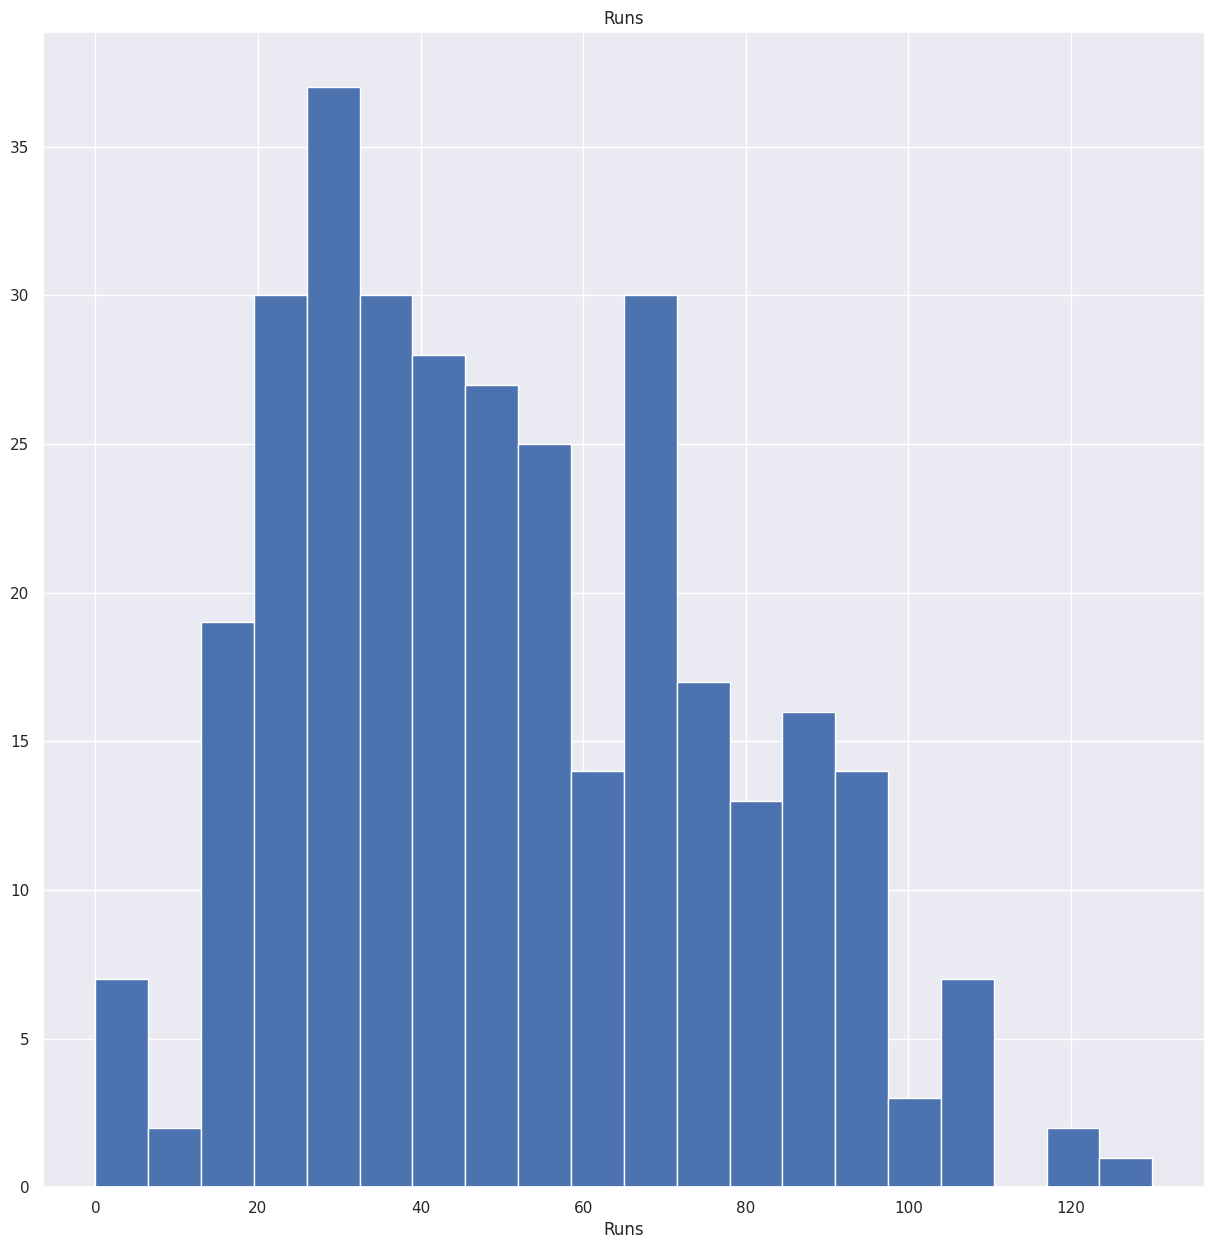

count   322.000
mean     48.028
std      26.167
min       0.000
5%       14.000
10%      19.000
20%      26.000
30%      30.000
40%      36.400
50%      44.000
60%      49.000
70%      58.000
80%      73.000
90%      86.000
95%      96.000
99%     112.370
max     121.000
Name: RBI, dtype: float64


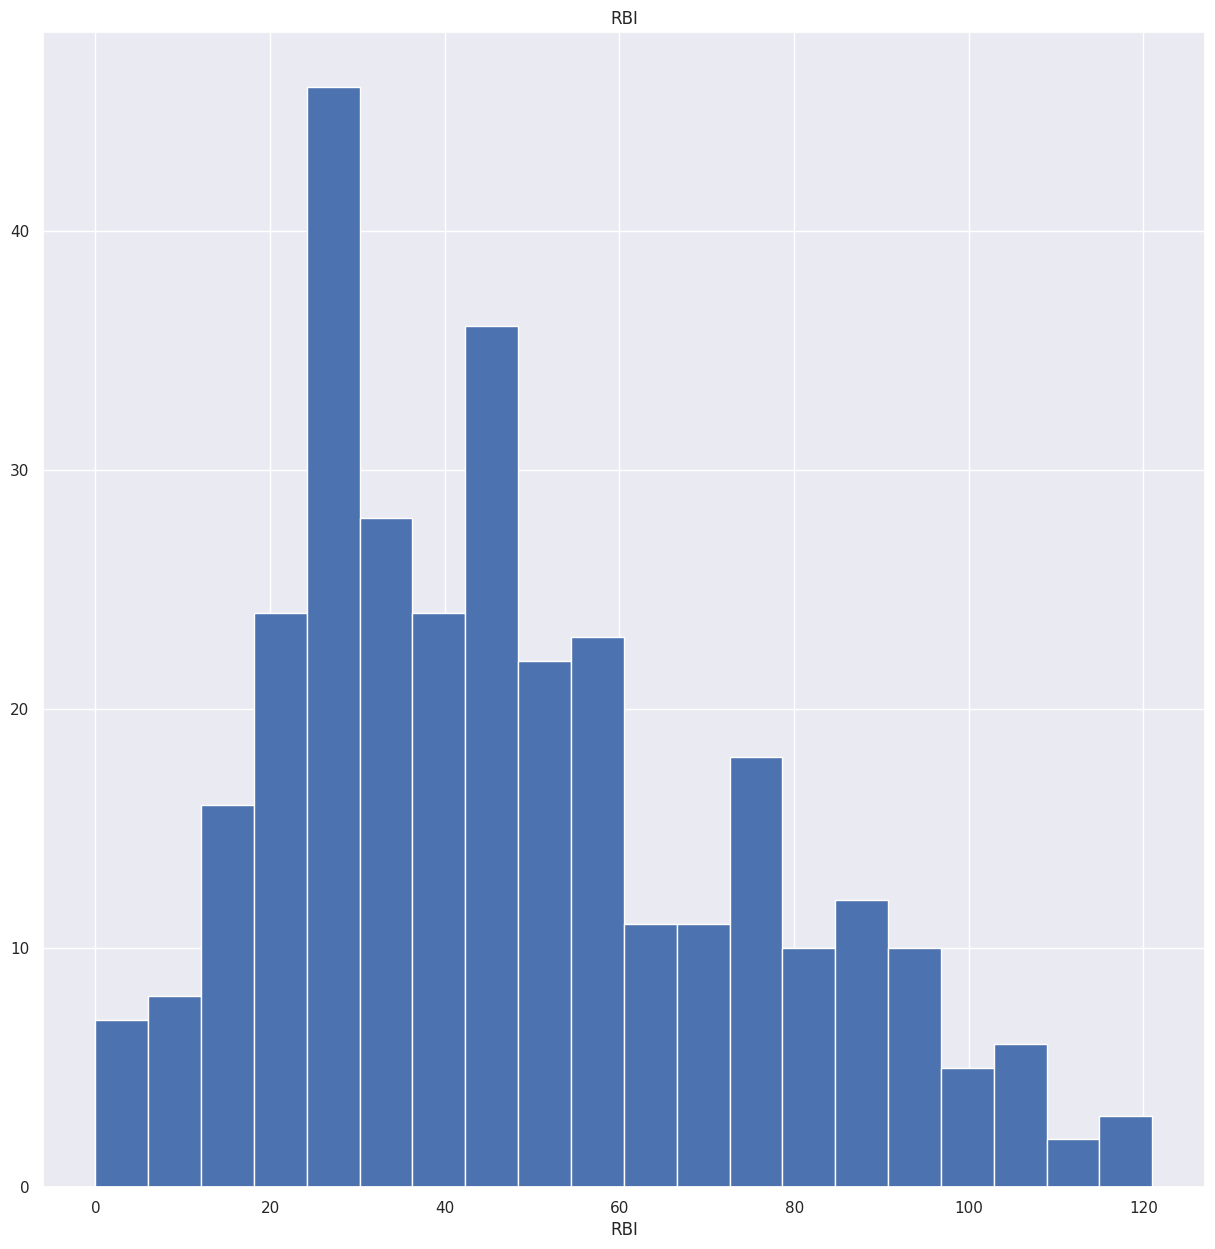

count   322.000
mean     38.742
std      21.639
min       0.000
5%       11.050
10%      15.000
20%      20.000
30%      24.000
40%      30.000
50%      35.000
60%      40.000
70%      48.700
80%      59.000
90%      69.900
95%      78.000
99%      93.580
max     105.000
Name: Walks, dtype: float64


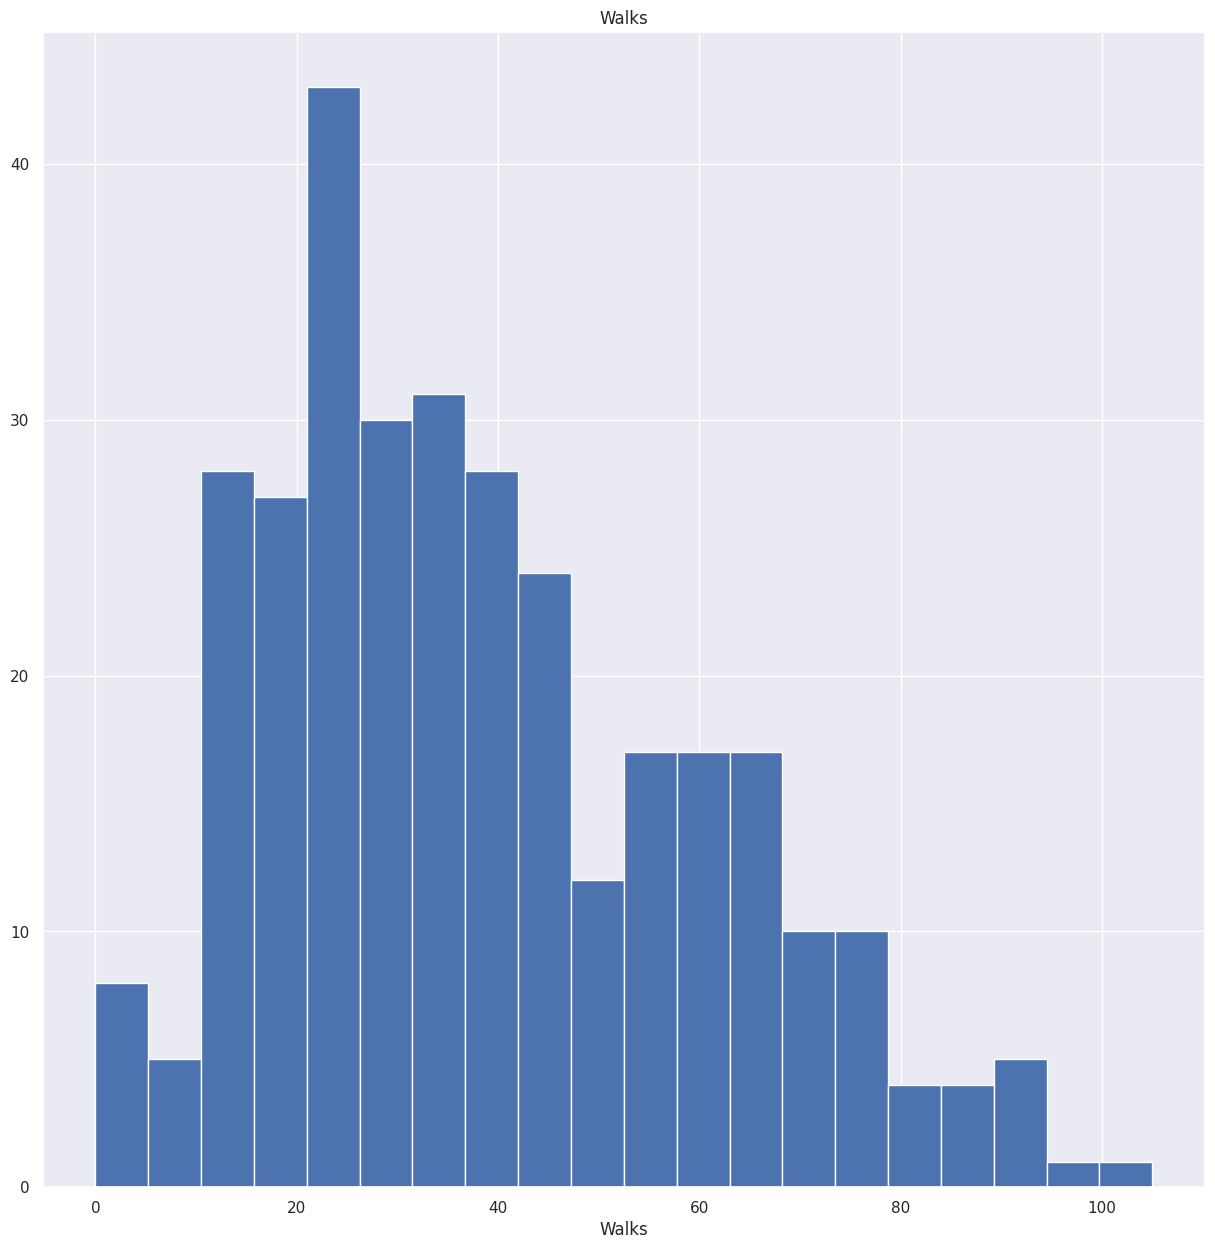

count   322.000
mean      7.444
std       4.926
min       1.000
5%        1.000
10%       2.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       7.600
70%      10.000
80%      12.000
90%      15.000
95%      17.000
99%      19.790
max      24.000
Name: Years, dtype: float64


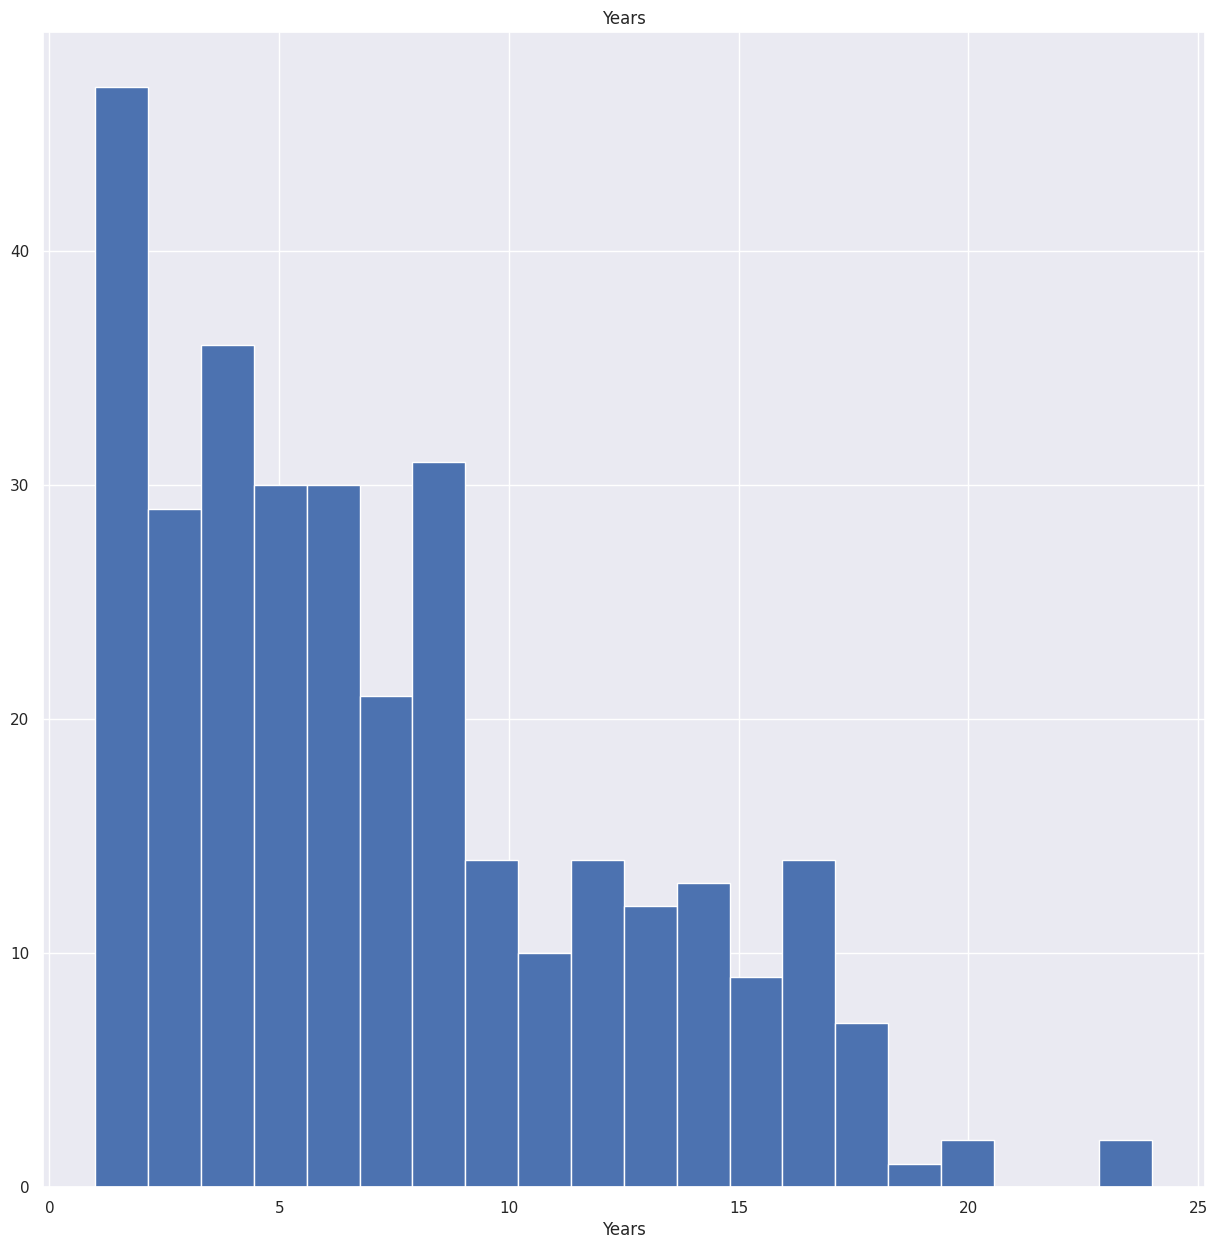

count     322.000
mean     2648.683
std      2324.206
min        19.000
5%        216.500
10%       342.200
20%       667.600
30%       963.400
40%      1402.200
50%      1928.000
60%      2654.000
70%      3365.000
80%      4483.000
90%      6123.400
95%      7125.600
99%      8749.970
max     14053.000
Name: CAtBat, dtype: float64


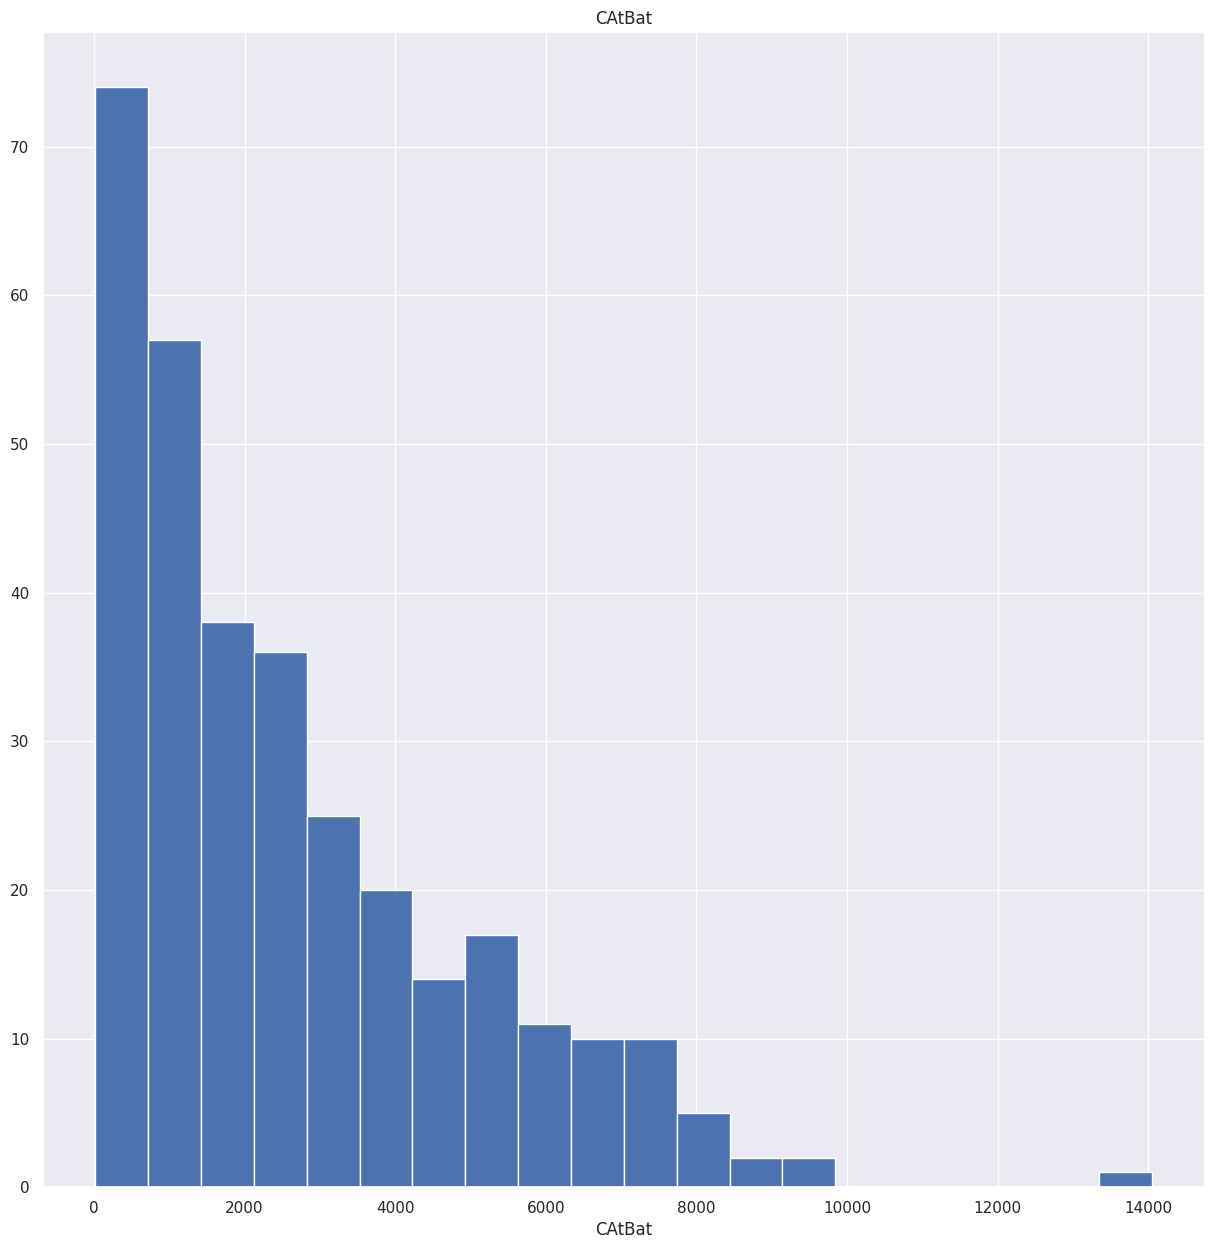

count    322.000
mean     717.571
std      654.473
min        4.000
5%        54.000
10%       86.000
20%      164.600
30%      238.000
40%      355.800
50%      508.000
60%      708.200
70%      911.100
80%     1229.200
90%     1659.600
95%     2017.150
99%     2500.340
max     4256.000
Name: CHits, dtype: float64


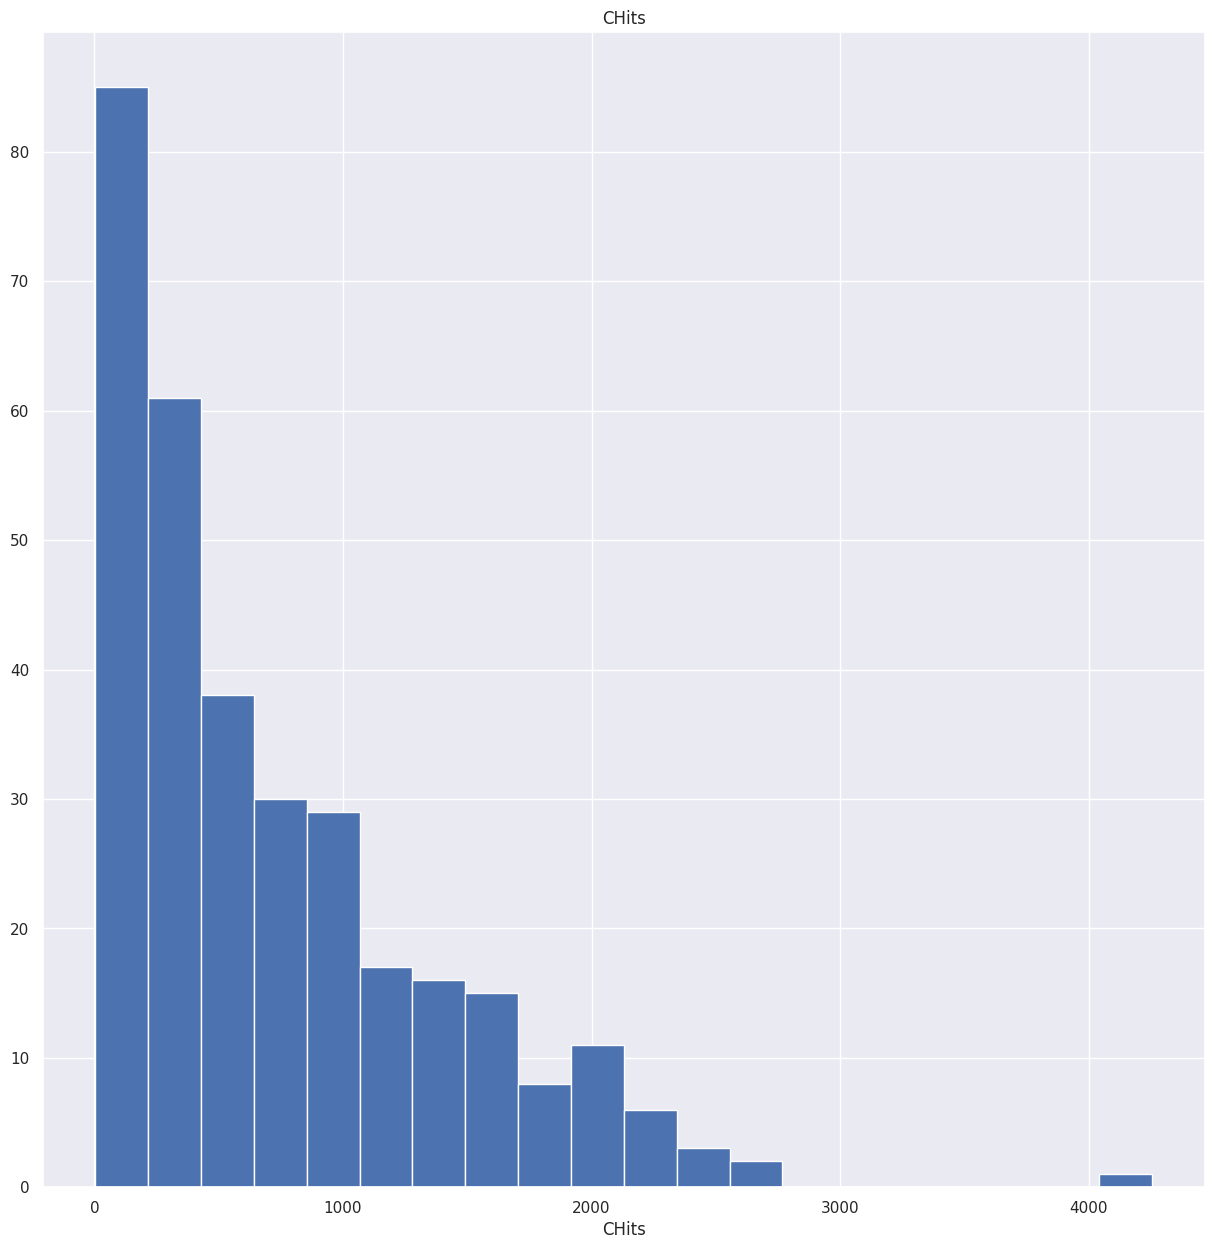

count   322.000
mean     69.491
std      86.266
min       0.000
5%        2.000
10%       4.000
20%      10.200
30%      16.300
40%      27.400
50%      37.500
60%      51.200
70%      72.400
80%     103.800
90%     194.900
95%     265.650
99%     373.120
max     548.000
Name: CHmRun, dtype: float64


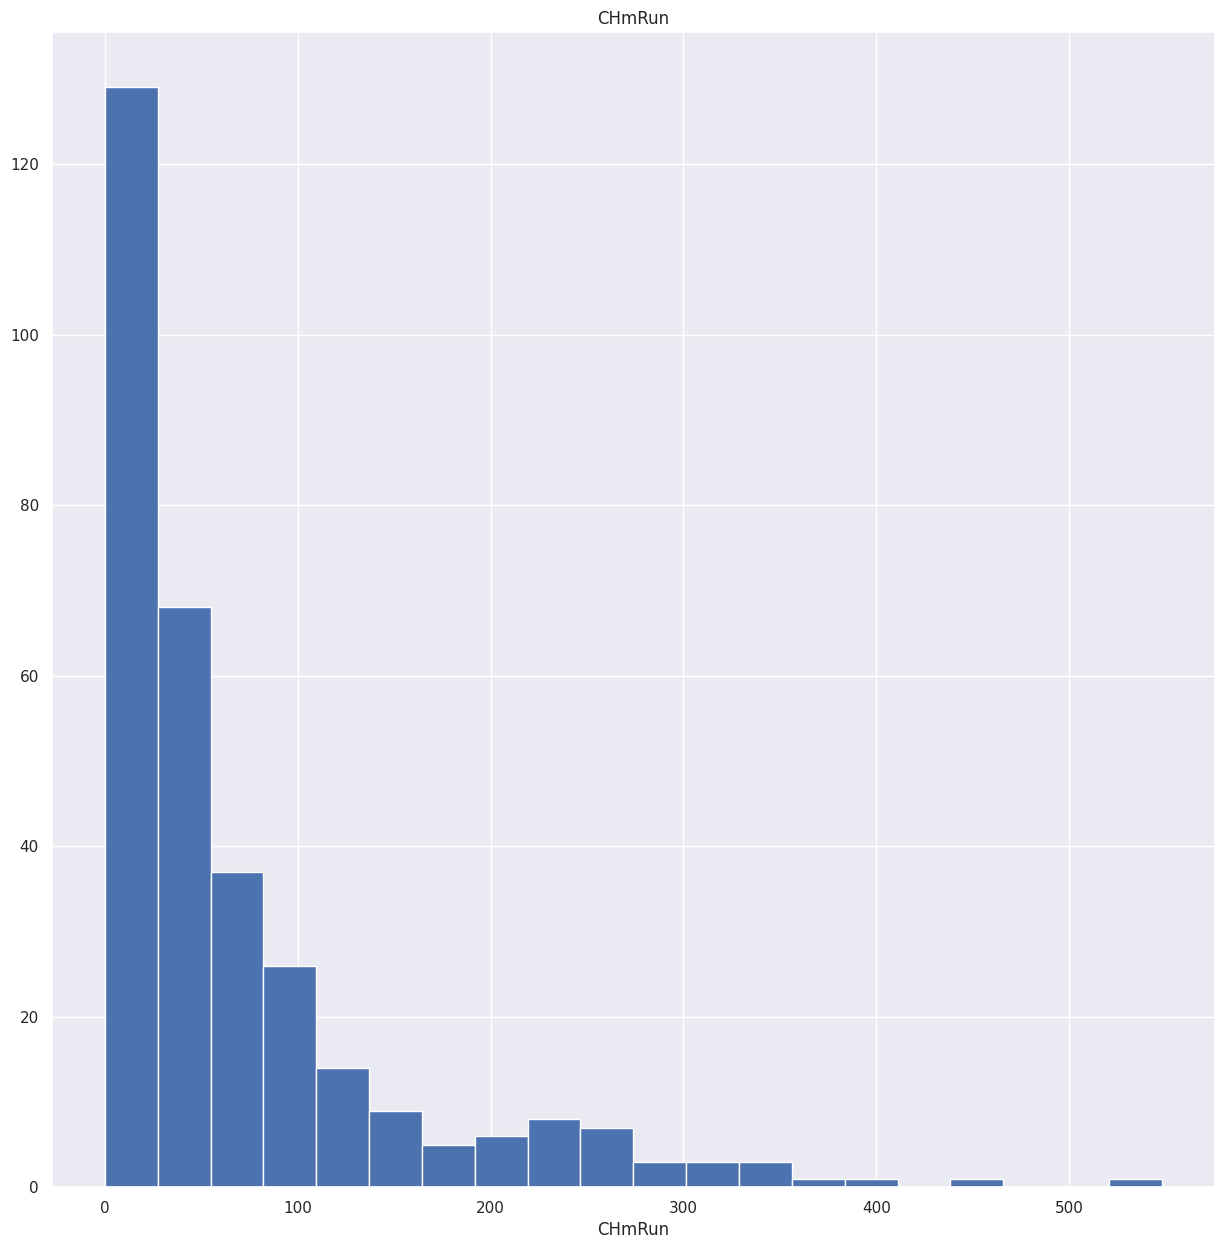

count    322.000
mean     358.795
std      334.106
min        1.000
5%        27.000
10%       38.100
20%       80.400
30%      117.300
40%      181.000
50%      247.000
60%      333.000
70%      443.400
80%      627.200
90%      895.700
95%     1032.300
99%     1174.370
max     2165.000
Name: CRuns, dtype: float64


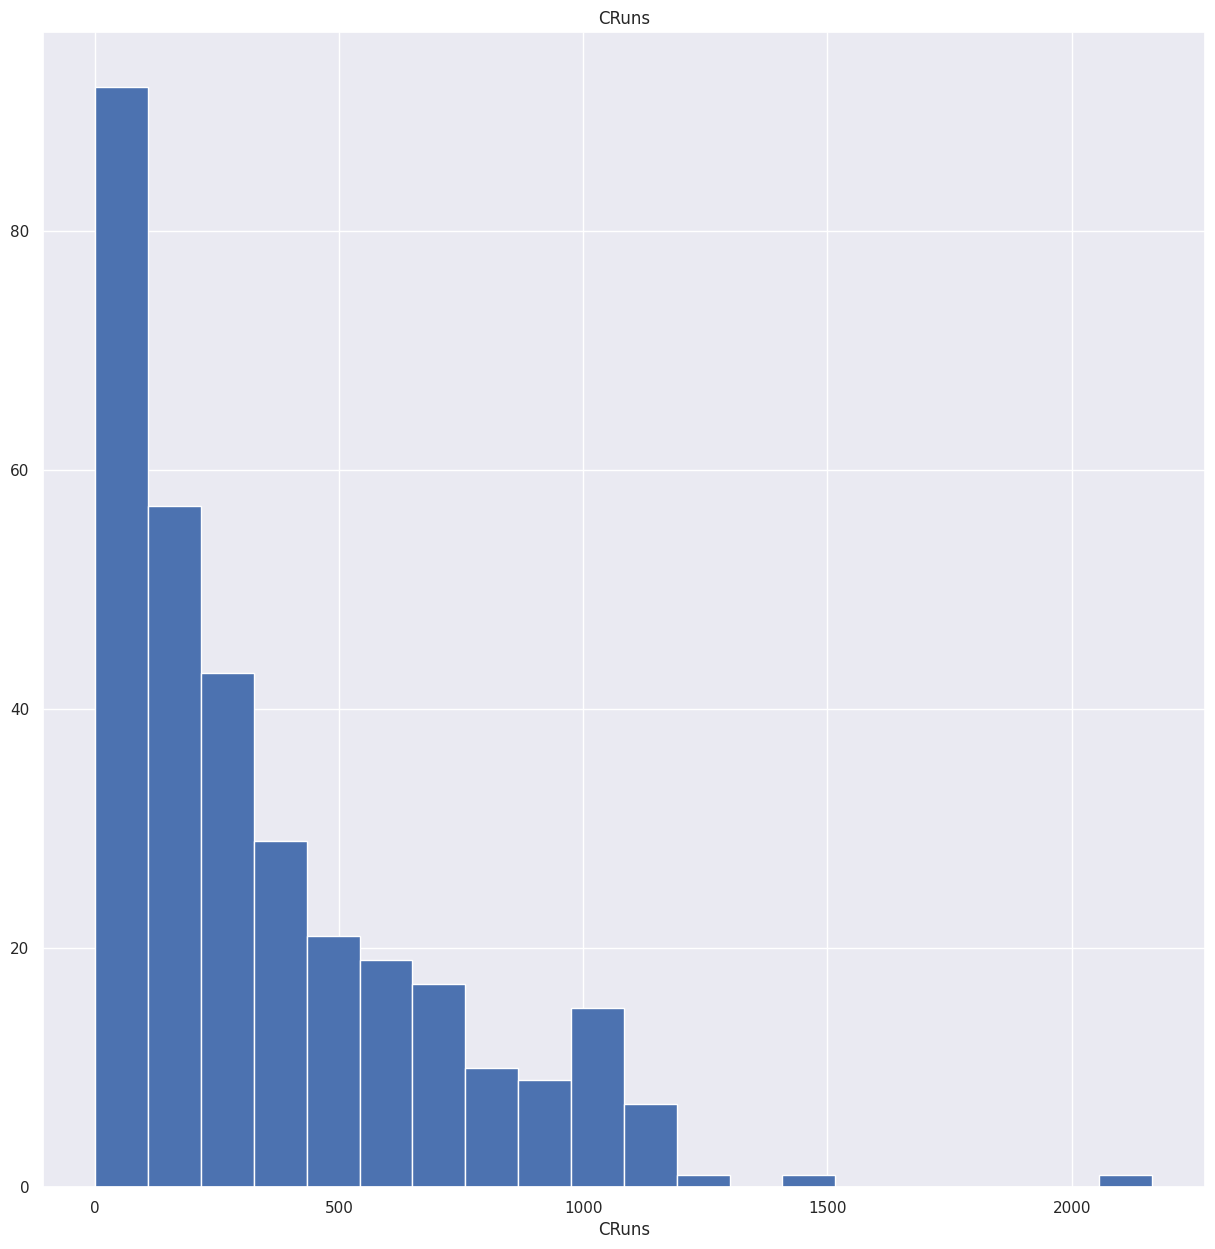

count    322.000
mean     330.118
std      333.220
min        0.000
5%        22.050
10%       34.100
20%       70.200
30%      106.300
40%      149.000
50%      220.500
60%      303.600
70%      379.100
80%      496.200
90%      861.600
95%     1071.750
99%     1310.850
max     1659.000
Name: CRBI, dtype: float64


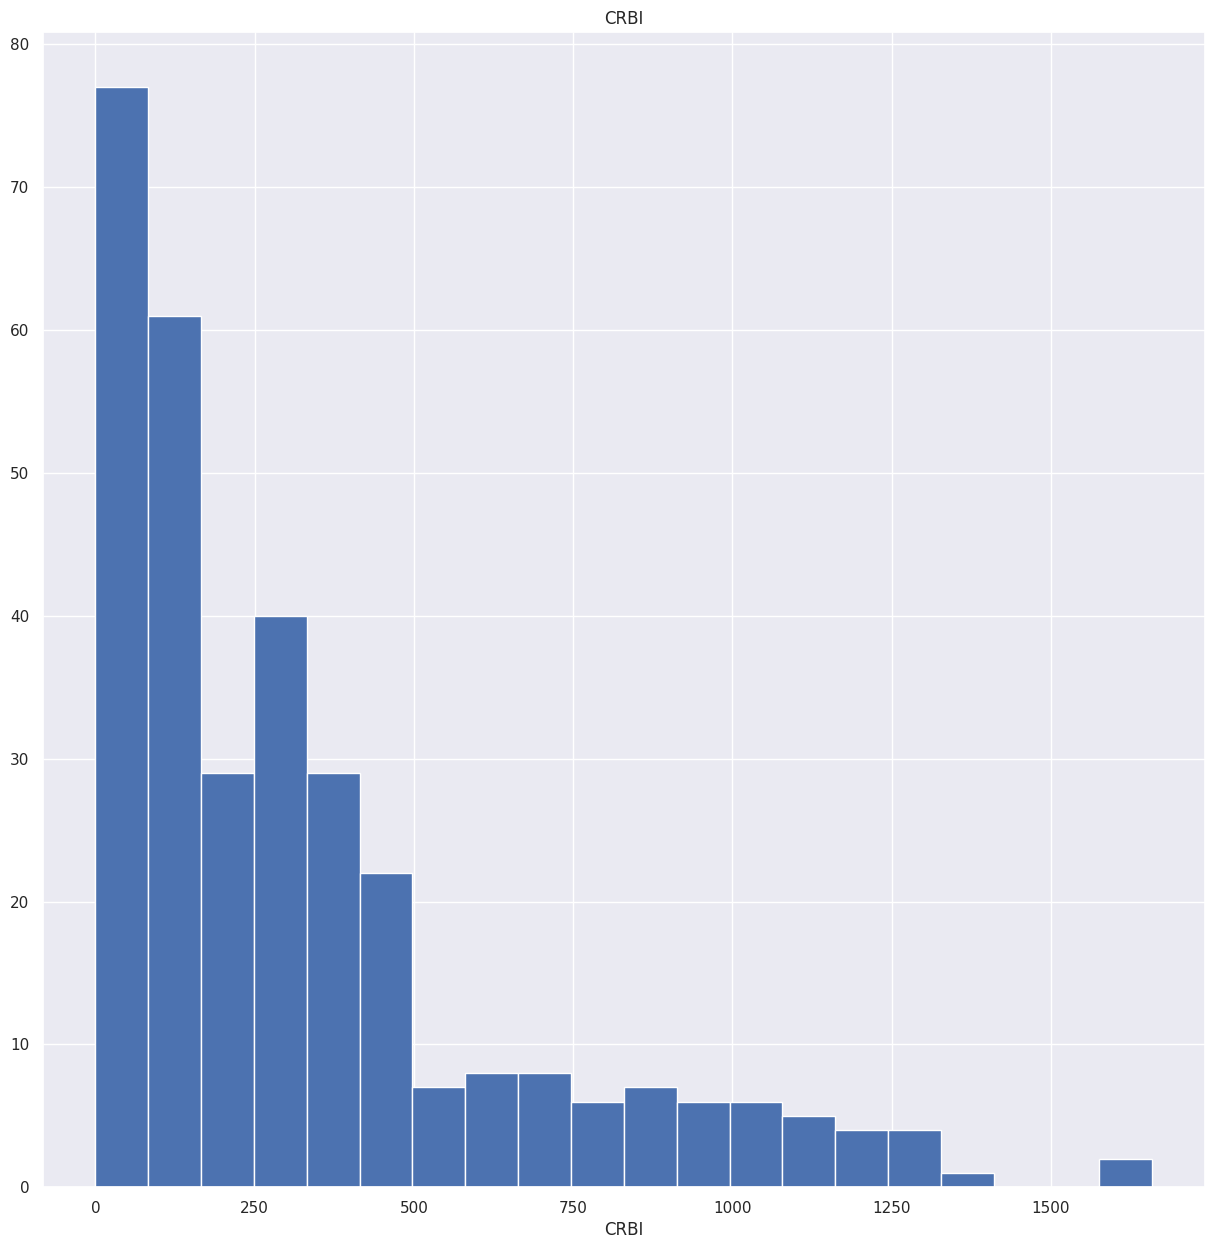

count    322.000
mean     260.239
std      267.058
min        0.000
5%        15.050
10%       30.100
20%       55.000
30%       82.000
40%      117.400
50%      170.500
60%      226.600
70%      300.700
80%      421.000
90%      643.900
95%      817.600
99%     1139.140
max     1566.000
Name: CWalks, dtype: float64


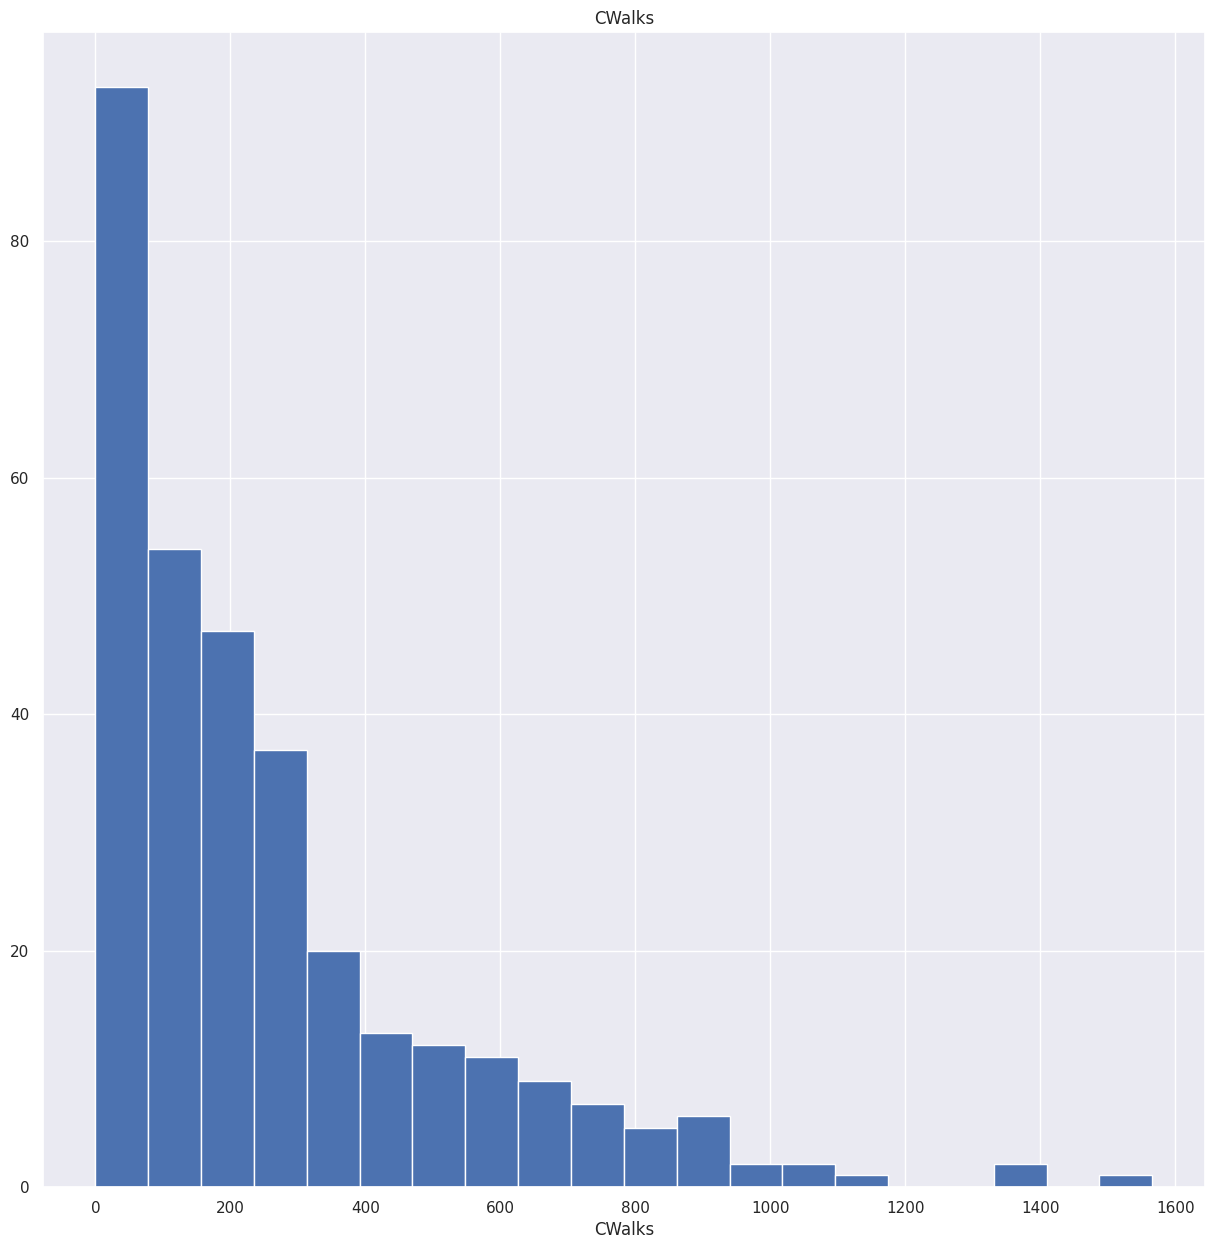

count    322.000
mean     288.938
std      280.705
min        0.000
5%        33.200
10%       62.200
20%       99.600
30%      132.000
40%      167.000
50%      212.000
60%      257.400
70%      303.000
80%      365.800
90%      685.600
95%      910.650
99%     1301.190
max     1378.000
Name: PutOuts, dtype: float64


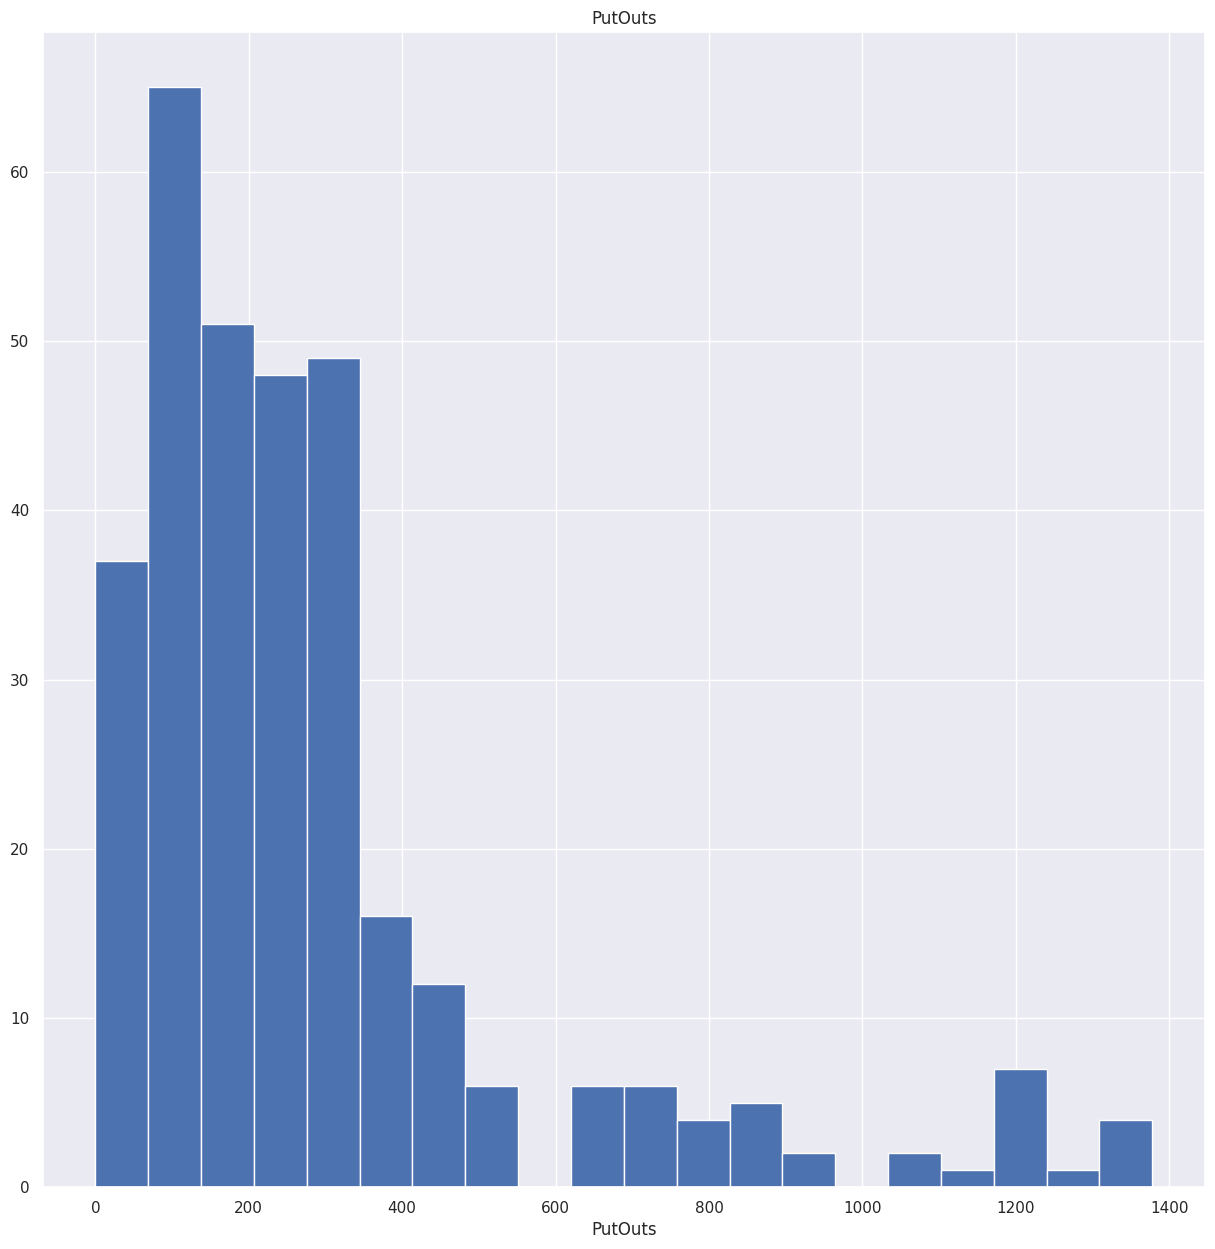

count   322.000
mean    106.913
std     136.855
min       0.000
5%        0.000
10%       2.000
20%       5.200
30%       9.000
40%      15.400
50%      39.500
60%      76.800
70%     134.800
80%     210.800
90%     353.300
95%     431.450
99%     478.160
max     492.000
Name: Assists, dtype: float64


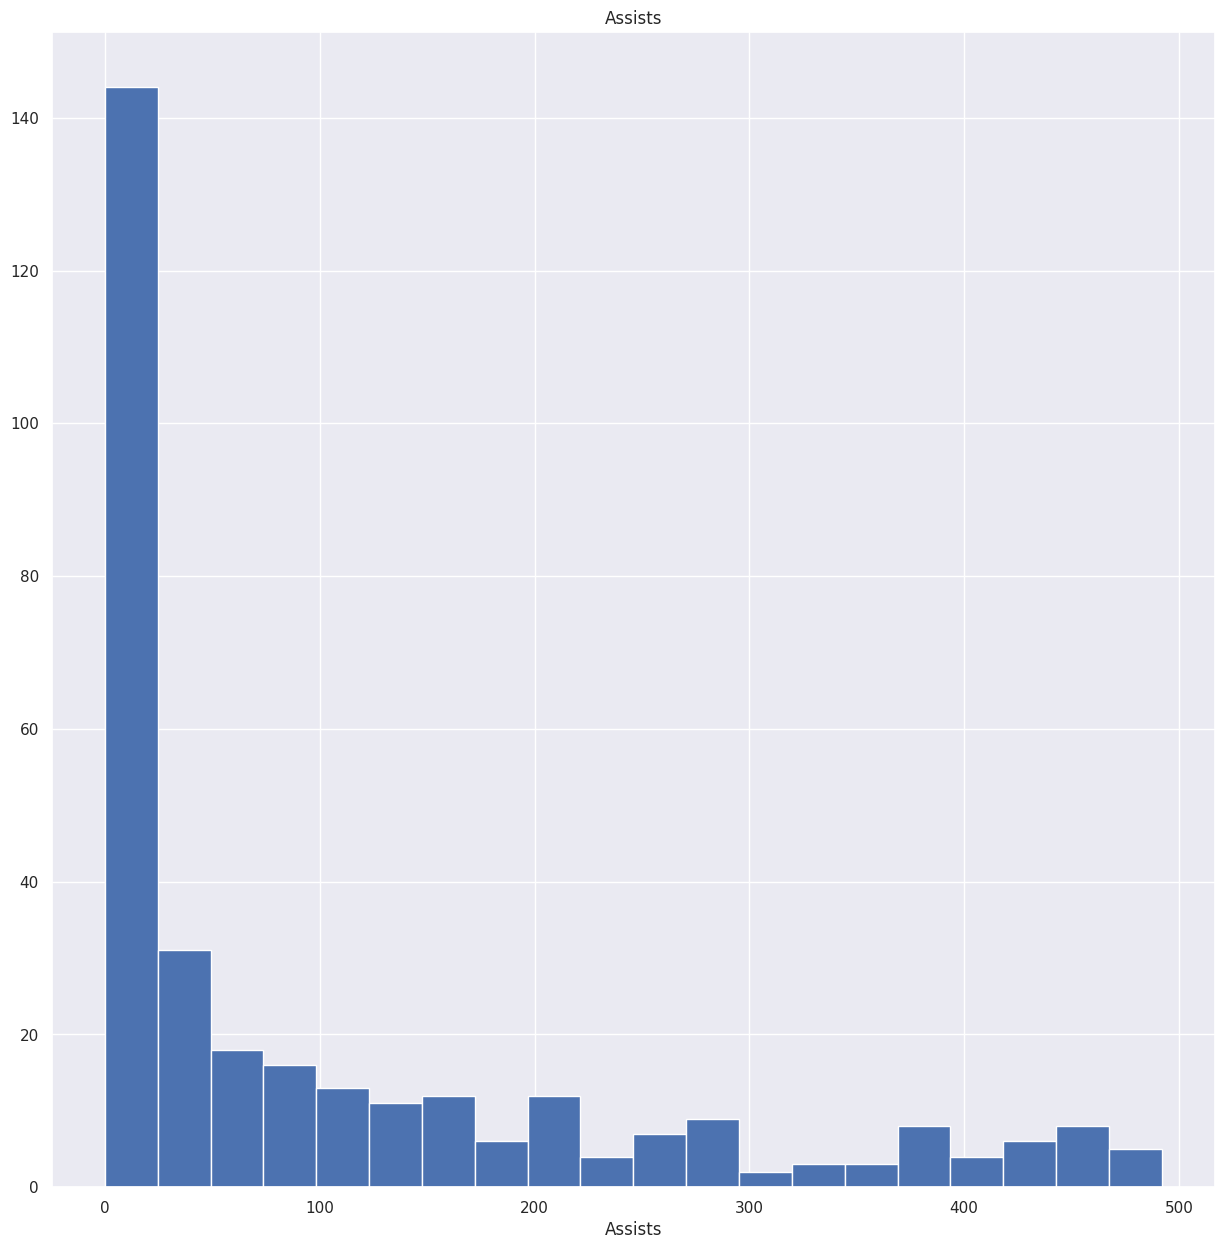

count   322.000
mean      8.040
std       6.368
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       8.000
70%      10.000
80%      13.000
90%      17.000
95%      20.000
99%      25.790
max      32.000
Name: Errors, dtype: float64


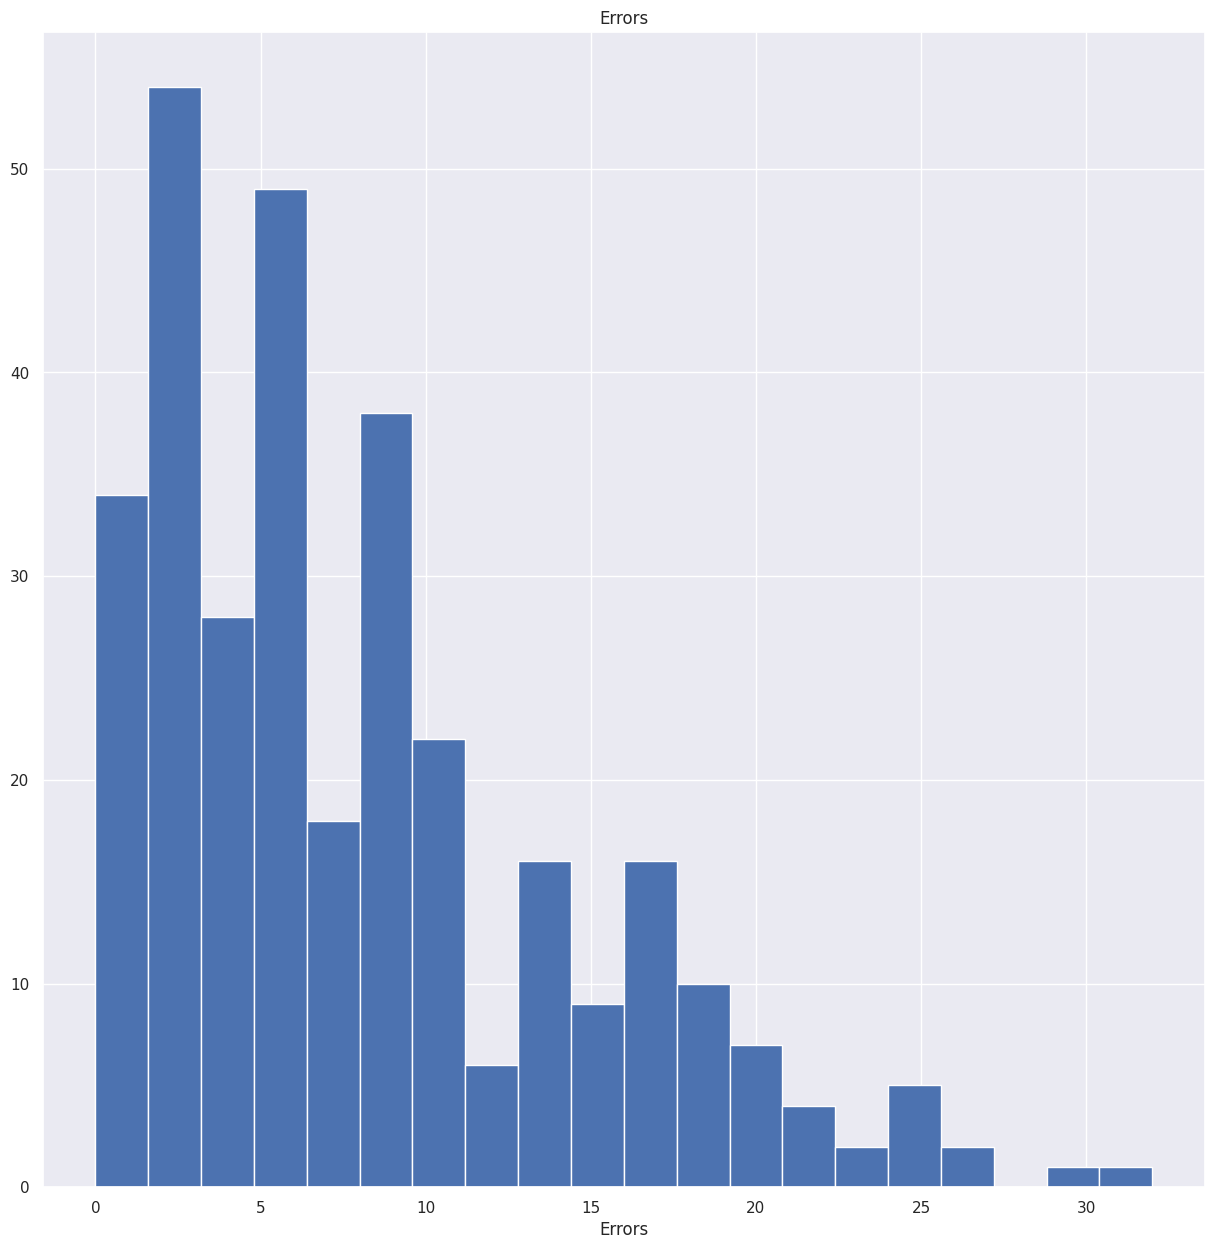

count    263.000
mean     535.926
std      451.119
min       67.500
5%        86.600
10%      100.000
20%      155.000
30%      221.000
40%      300.000
50%      425.000
60%      538.000
70%      700.000
80%      809.000
90%     1048.667
95%     1346.000
99%     2032.887
max     2460.000
Name: Salary, dtype: float64


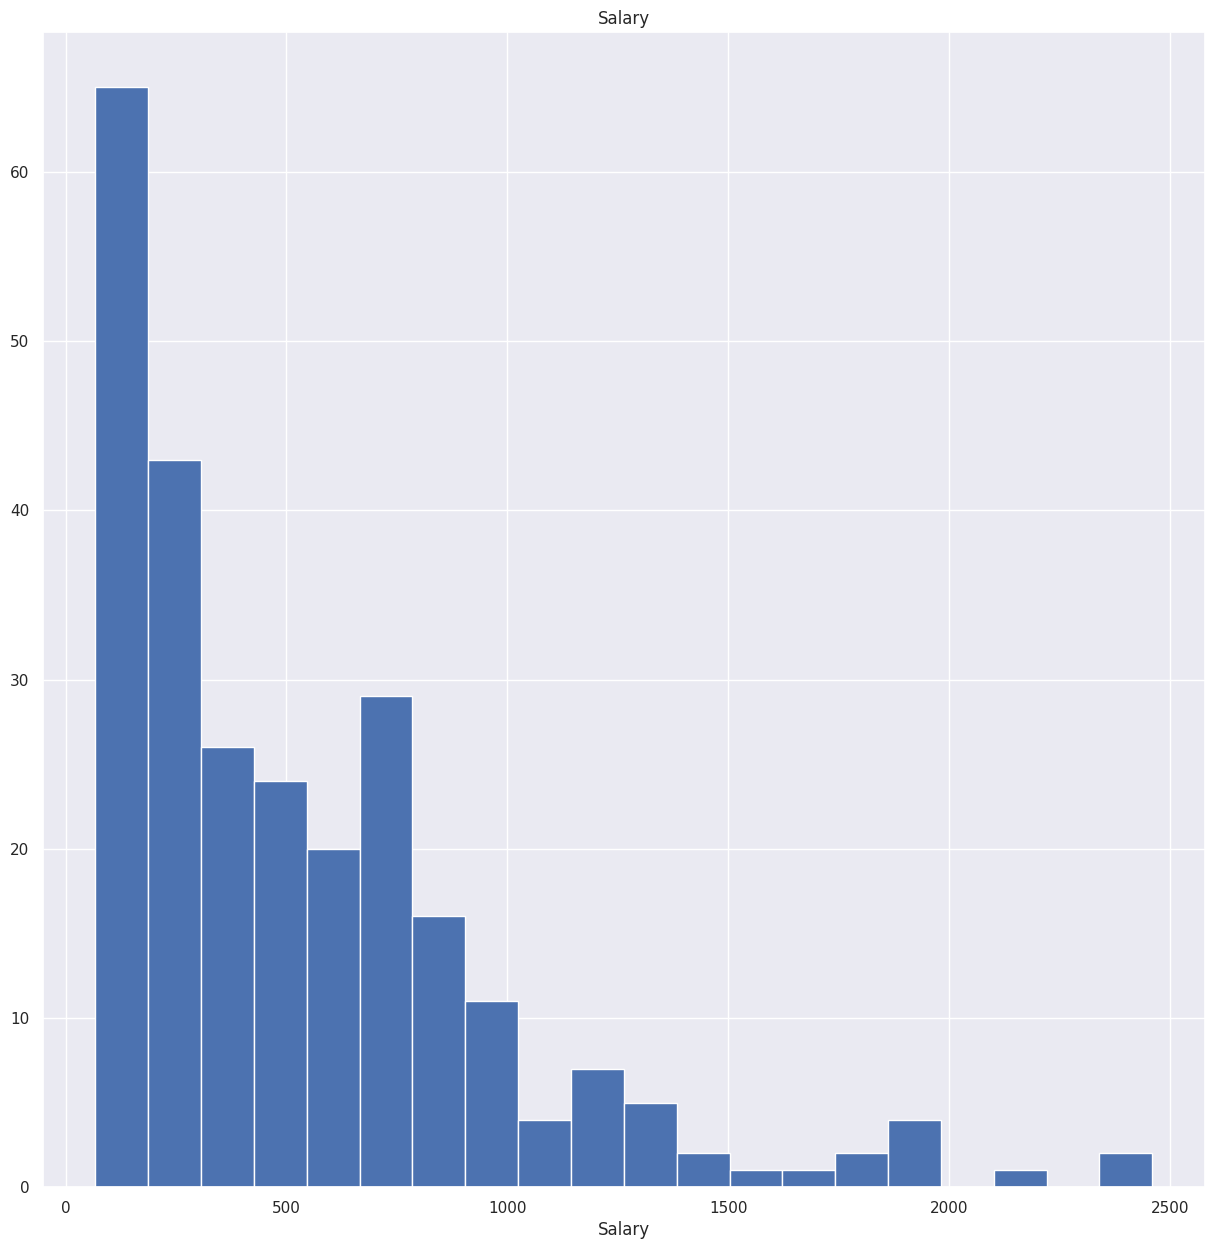

In [93]:
#Numerik değişken analizi
def num_summary(dataframe, numerical_col, plot=False):
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[numerical_col].describe(quantiles).T)
  if plot:
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.title(numerical_col)
    plt.show(block=True)

for col in num_cols:
  num_summary(df, col, plot=True)

In [94]:
#Hedef değişkenin kategorik değişkenler ile analizi
def target_vs_cat(dataframe, target, categorical_col):
  print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
  print("###################################")

for col in cat_cols:
  target_vs_cat(df, "Salary", col)

        TARGET_MEAN
League             
A           542.000
N           529.118


###################################
          TARGET_MEAN
Division             
E             624.271
W             450.877


###################################
           TARGET_MEAN
NewLeague             
A              537.113
N              534.554


###################################


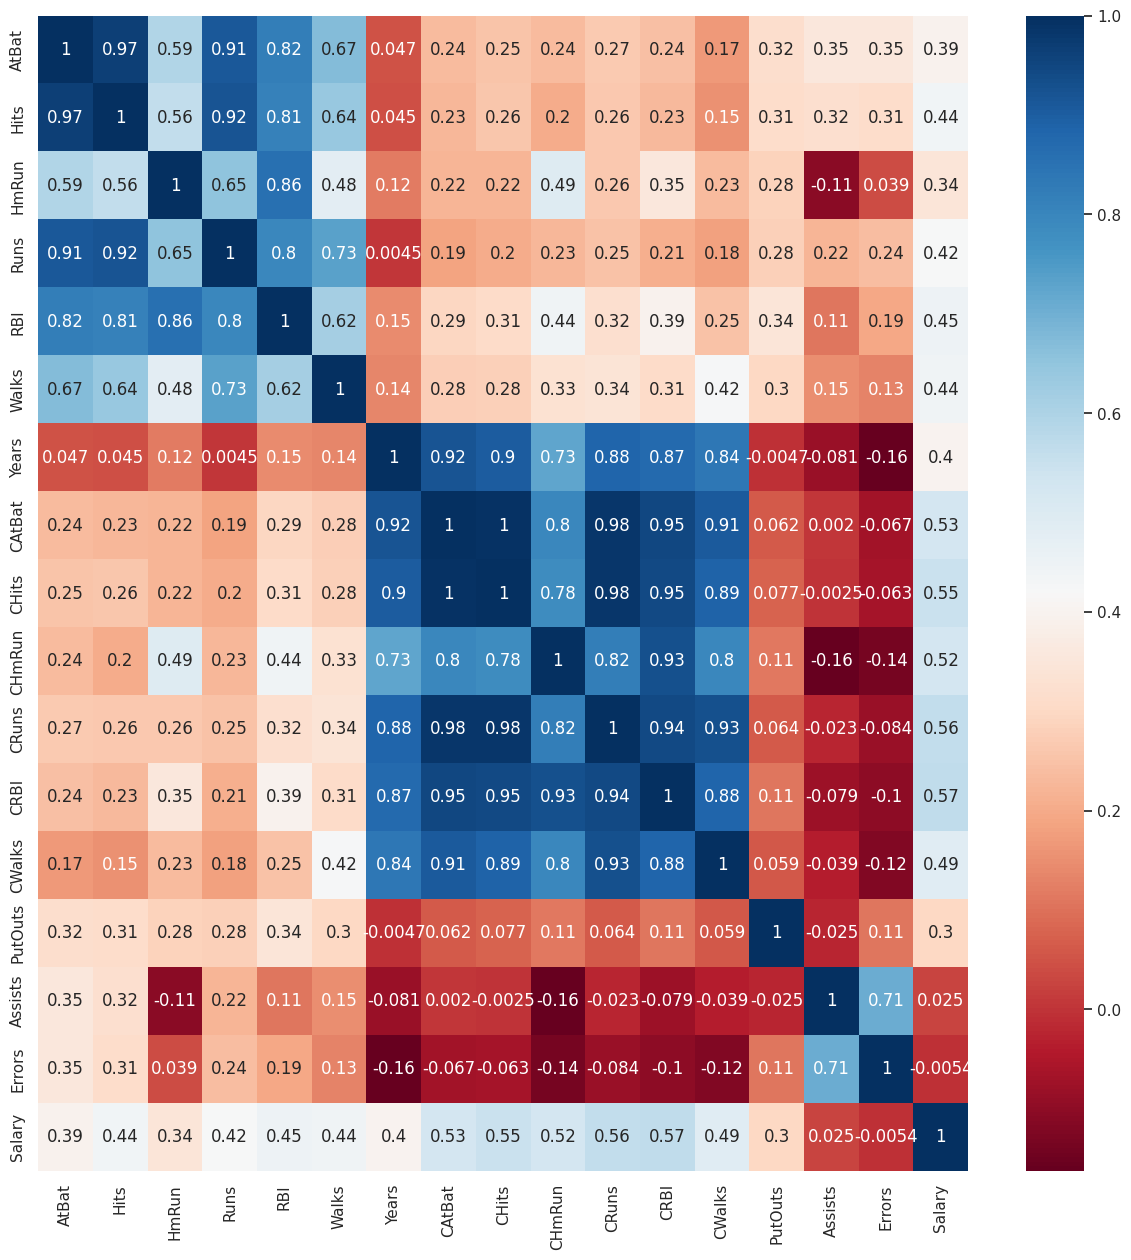

In [95]:
#Korelasyon analizi
corr = df[num_cols].corr()

sns.set(rc={"figure.figsize": (15,15)})
sns.heatmap(corr, annot=True, cmap="RdBu")
plt.show(block=True)

In [96]:
#Birbirleri arasında yüksek korelasyona sahip değişkenler
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):

    dataframe = df.select_dtypes(include=[np.number])

    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show(block=True)
    return drop_list
high_correlated_cols(df, plot=False)

['Hits',
 'Runs',
 'RBI',
 'Walks',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'Errors']

Outliers(Aykırı Değerler):

In [97]:

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5*interquantile_range
  low_limit = quartile1 - 1.5*interquantile_range
  return low_limit, up_limit

def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

for col in num_cols:
    print(col, check_outlier(df, col))

AtBat False
Hits False
HmRun True
Runs True
RBI True
Walks True
Years True
CAtBat True
CHits True
CHmRun True
CRuns True
CRBI True
CWalks True
PutOuts True
Assists True
Errors True
Salary True


In [98]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # Sütunun türünü float yaptık. Yoksa hata alıyoruz.
    #dataframe[variable] = dataframe[variable].astype(float)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
Salary False


Missing Values(Eksik Değerler):

In [99]:
#Eksik değer kontrolü
def missing_values_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0]*100)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
  print(missing_df, end="\n")

  if na_name:
      return na_columns

missing_values_table(df)

        n_miss  ratio
Salary      59 18.320


In [100]:
df.dropna(inplace=True)

In [101]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [78]:
#İstersek mean de alabiliriz. Median rmse değerini arttırdı.
#df["Salary"].fillna(df["Salary"].median(), inplace=True)
#missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [102]:
#Yeni değişken oluşturma
new_num_cols=[col for col in num_cols if col!="Salary"]

df[new_num_cols]=df[new_num_cols]+0.0000000001

df['NEW_Hits'] = df['Hits'] / df['CHits'] + df['Hits']
df['NEW_RBI'] = df['RBI'] / df['CRBI']
df['NEW_Walks'] = df['Walks'] / df['CWalks']
df['NEW_PutOuts'] = df['PutOuts'] * df['Years']
df["Hits_Success"] = (df["Hits"] / df["AtBat"]) * 100
df["NEW_CRBI*CATBAT"] = df['CRBI'] * df['CAtBat']
df["NEW_RBI"] = df["RBI"] / df["CRBI"]
df["NEW_Chits"] = df["CHits"] / df["Years"]
df["NEW_CHmRun"] = df["CHmRun"] * df["Years"]
df["NEW_CRuns"] = df["CRuns"] / df["Years"]
df["NEW_Chits"] = df["CHits"] * df["Years"]
df["NEW_RW"] = df["RBI"] * df["Walks"]
df["NEW_RBWALK"] = df["RBI"] / df["Walks"]
df["NEW_CH_CB"] = df["CHits"] / df["CAtBat"]
df["NEW_CHm_CAT"] = df["CHmRun"] / df["CAtBat"]
df['NEW_Diff_Atbat'] = df['AtBat'] - (df['CAtBat'] / df['Years'])
df['NEW_Diff_Hits'] = df['Hits'] - (df['CHits'] / df['Years'])
df['NEW_Diff_HmRun'] = df['HmRun'] - (df['CHmRun'] / df['Years'])
df['NEW_Diff_Runs'] = df['Runs'] - (df['CRuns'] / df['Years'])
df['NEW_Diff_RBI'] = df['RBI'] - (df['CRBI'] / df['Years'])
df['NEW_Diff_Walks'] = df['Walks'] - (df['CWalks'] / df['Years'])

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 263
Variables: 39
cat_cols: 3
num_cols: 36
cat_but_car: 0
num_but_cat: 0


Encoding:

In [103]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and len(df[col].unique()) == 2]

for col in binary_cols:
  label_encoder(df, col)

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [104]:
check_df(df)

##################### Shape #####################
(263, 39)
##################### Types #####################
AtBat             float64
Hits              float64
HmRun             float64
Runs              float64
RBI               float64
                   ...   
NEW_Diff_RBI      float64
NEW_Diff_Walks    float64
League_1             bool
Division_1           bool
NewLeague_1          bool
Length: 39, dtype: object
##################### Head #####################
    AtBat    Hits  HmRun   Runs    RBI  Walks  Years   CAtBat    CHits  CHmRun   CRuns    CRBI  CWalks  PutOuts  Assists  Errors  Salary  NEW_Hits  NEW_RBI  NEW_Walks  \
1 315.000  81.000  7.000 24.000 38.000 39.000 14.000 3449.000  835.000  69.000 321.000 414.000 375.000  632.000   43.000  10.000 475.000    81.097    0.092      0.104   
2 479.000 130.000 18.000 66.000 72.000 76.000  3.000 1624.000  457.000  63.000 224.000 266.000 263.000  648.625   82.000  14.000 480.000   130.284    0.271      0.289   
3 496.000 141.000 2

In [105]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in ["Salary"]]

Observations: 263
Variables: 39
cat_cols: 3
num_cols: 36
cat_but_car: 0
num_but_cat: 3


Scalling:

In [106]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Runs,NEW_Diff_RBI,NEW_Diff_Walks,League_1,Division_1,NewLeague_1
1,-0.603,-0.596,-0.530,-1.207,-0.522,-0.097,1.409,0.373,0.201,0.110,-0.113,0.366,0.592,2.072,-0.528,0.242,475.000,-0.601,-0.836,-0.793,3.327,-0.168,0.011,0.371,0.302,-1.063,-0.466,-0.580,-0.873,-0.273,-0.004,0.093,-0.280,-0.473,-0.213,0.155,True,True,True
2,0.513,0.492,0.738,0.442,0.795,1.615,-0.905,-0.461,-0.418,0.012,-0.425,-0.169,0.081,2.163,-0.242,0.877,480.000,0.492,-0.230,-0.149,0.056,0.277,-0.468,-0.617,-0.502,1.419,1.488,-0.613,0.805,1.012,-1.149,-1.229,-1.283,-1.010,-1.676,-1.501,False,True,False
3,0.628,0.736,0.969,0.403,1.027,-0.189,0.778,1.369,1.413,2.305,1.518,1.898,0.496,-0.301,-0.762,-0.871,500.000,0.732,-0.831,-0.791,0.176,0.679,1.594,0.910,1.624,1.448,0.221,0.782,0.739,0.838,-0.741,-0.619,-0.402,-1.098,-0.599,-0.358,True,False,True
4,-0.562,-0.462,-0.184,-0.618,-0.367,-0.513,-1.115,-1.022,-1.002,-0.817,-0.991,-0.964,-0.969,2.163,-0.550,-0.712,91.500,-0.451,1.943,2.008,-0.252,0.265,-0.668,-0.729,-0.673,-1.011,-0.575,-0.069,-0.320,0.432,0.471,0.551,0.101,0.295,0.403,0.244,True,False,True
5,1.295,1.358,-0.876,0.757,-0.019,-0.282,0.778,0.812,0.689,-0.704,0.466,0.084,-0.234,0.150,2.118,2.307,750.000,1.355,-0.633,-0.527,0.604,0.686,0.037,0.445,-0.481,0.022,-0.318,-0.000,-0.235,-1.346,1.086,1.443,-0.240,1.036,0.488,0.512,False,True,False


Model Kurma:

In [107]:
dff= df.copy()

In [108]:
y = dff["Salary"]
X = dff.drop(["Salary"], axis=1)

models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name})")

RMSE: 236.0151 (LR)
RMSE: 253.4936 (KNN)
RMSE: 300.3586 (CART)
RMSE: 207.4804 (RF)
RMSE: 198.9773 (GBM)
RMSE: 217.7508 (XGBoost)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2430
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 38
[LightGBM] [Info] Start training from score 525.722458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

Hiperparametre Optimizasyonu

Buradaki en iyi model RandomForest çıktı ancak diğer modeller ile arasındaki fark çok az o yüzden diğer modelleride denemeliyiz.

In [109]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)

rf_model = RandomForestRegressor(random_state = 17)

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, 9],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(rf_final, X, y, cv=10, scoring="neg_mean_squared_error")))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [111]:
rmse

213.82219579890793

In [112]:
gbm_model = GradientBoostingRegressor(random_state=17)

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=10, n_jobs=-1, verbose=True).fit(X, y)
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(gbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


In [113]:
rmse

201.01738268876093